In [ ]:
!pip install --ignore-installed tbb
!pip install torch --user
!pip install torchvision --user

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, InterpolationMode
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.functional import resize

from pathlib import Path

import matplotlib.pyplot as plt

print('Using PyTorch version:', torch.__version__)
if torch.cuda.is_available():
    print('Using GPU, device name:', torch.cuda.get_device_name(0))
    device = torch.device('cuda')
else:
    print('No GPU found, using CPU instead.')
    device = torch.device('cpu')

Using PyTorch version: 2.3.0+cpu
No GPU found, using CPU instead.


In [3]:
batch_size = 32
NUM_OF_CLASSES = 10

data_dir = './data'
print('data_dir =', data_dir)

train_dataset = datasets.MNIST(data_dir, train=True,
                               download=True, transform=ToTensor())
test_dataset = datasets.MNIST(data_dir, train=False,
                              transform=ToTensor())

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size,
                         shuffle=True)

data_dir = ./data


In [4]:
for (data, target) in train_loader:
    print('data:', data.size(), 'type:', data.type())
    print('target:', target.size(), 'type:', target.type())
    break

data: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
target: torch.Size([32]) type: torch.LongTensor


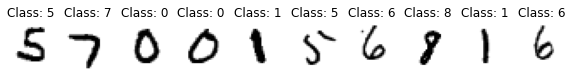

In [5]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(data[i,:,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(target[i].item()))

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Linear(50, NUM_OF_CLASSES)
        )

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
print(model)

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): ReLU()
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [8]:
def correct(output, target):
    predicted_digits = output.argmax(1)                            # pick digit with largest network output
    correct_ones = (predicted_digits == target).type(torch.float)  # 1.0 for correct, 0.0 for incorrect
    return correct_ones.sum().item()                               # count number of correct ones


In [9]:
def train(data_loader, model, criterion, optimizer):
    model.train()

    num_batches = len(data_loader)
    num_items = len(data_loader.dataset)

    total_loss = 0
    total_correct = 0
    for data, target in data_loader:
        # Copy data and targets to GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        total_loss += loss

        # Count number of correct digits
        total_correct += correct(output, target)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    train_loss = total_loss/num_batches
    accuracy = total_correct/num_items
    print(f"Average loss: {train_loss:6f}, accuracy: {accuracy:.2%}")


In [10]:
%%time

epochs = 20
for epoch in range(epochs):
    print(f"Training epoch: {epoch+1}")
    train(train_loader, model, criterion, optimizer)

Training epoch: 1
Average loss: 0.361467, accuracy: 90.06%
Training epoch: 2
Average loss: 0.182444, accuracy: 94.77%
Training epoch: 3
Average loss: 0.133188, accuracy: 96.16%
Training epoch: 4
Average loss: 0.107342, accuracy: 96.86%
Training epoch: 5
Average loss: 0.089036, accuracy: 97.33%
Training epoch: 6
Average loss: 0.077352, accuracy: 97.61%
Training epoch: 7
Average loss: 0.067964, accuracy: 97.97%
Training epoch: 8
Average loss: 0.059612, accuracy: 98.16%
Training epoch: 9
Average loss: 0.053596, accuracy: 98.38%
Training epoch: 10
Average loss: 0.047490, accuracy: 98.58%
Training epoch: 11
Average loss: 0.043131, accuracy: 98.66%
Training epoch: 12
Average loss: 0.039104, accuracy: 98.84%
Training epoch: 13
Average loss: 0.035232, accuracy: 98.92%
Training epoch: 14
Average loss: 0.032329, accuracy: 99.01%
Training epoch: 15
Average loss: 0.028681, accuracy: 99.13%
Training epoch: 16
Average loss: 0.026641, accuracy: 99.19%
Training epoch: 17
Average loss: 0.024346, accura

In [11]:
def test(test_loader, model, criterion):
    model.eval()

    num_batches = len(test_loader)
    num_items = len(test_loader.dataset)

    test_loss = 0
    total_correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = model(data)

            loss = criterion(output, target)
            test_loss += loss.item()

            total_correct += correct(output, target)

    test_loss = test_loss/num_batches
    accuracy = total_correct/num_items

    print(f"Testset accuracy: {100*accuracy:>0.1f}%, average loss: {test_loss:>6f}")

    pltsize = 1
    plt.figure(figsize=(10*pltsize, pltsize))

    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.axis('off')
        plt.imshow(data[i,:,:,:].numpy().reshape(28, 28), cmap="gray_r")
        plt.title('Class: '+str(target[i].item()))

Testset accuracy: 97.2%, average loss: 0.111828


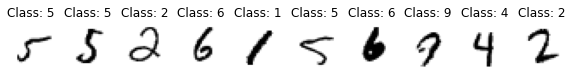

In [12]:
test(test_loader, model, criterion)

In [ ]:
from PIL import Image, ImageDraw
import PIL
from tkinter import *

width = 112  # canvas width
height = 112 # canvas height
bg = (0, 0, 0) # canvas background

def save():
    # save image to disk
    filename = "./data/user_input.jpg"
    output_image.save(filename)

def paint(event):
    x1, y1 = (event.x - 1), (event.y - 1)
    x2, y2 = (event.x + 1), (event.y + 1)
    canvas.create_oval(x1, y1, x2, y2, fill="white", width=10)
    draw.line([x1, y1, x2, y2], fill="white", width=10)

master = Tk()

# create a tkinter canvas
canvas = Canvas(master, width=width, height=height, bg='white')
canvas.pack()

# create empty PIL image and draw object to draw on
output_image = PIL.Image.new("RGB", (width, height), bg)
draw = ImageDraw.Draw(output_image)
canvas.pack(expand=YES, fill=BOTH)
canvas.bind("<B1-Motion>", paint)

# button to save the image
button=Button(text="save", command=save)
button.pack()

master.mainloop()

In [ ]:
user_image = read_image(str(Path('./data') / 'user_input.jpg'), mode=ImageReadMode.GRAY)
user_image = resize(user_image, [28, 28], interpolation=InterpolationMode.BILINEAR).to(torch.float32)

plt.imshow(user_image.numpy().reshape(28, 28), cmap="gray_r")

In [ ]:
def predict(data, model):
    output = model(data)

    out_soft = nn.functional.softmax(output, dim=1)[0]
    out_idx = torch.topk(out_soft, 1).indices
    out_class = out_idx.squeeze().item()

    print("Predicted number is", out_class)

In [ ]:
predict(user_image, model)